Importing the libraries

In [1]:
!pip install datasets

In [2]:
!pip install tensorflow_text

In [3]:
import os
#import shutil
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
import warnings
warnings.filterwarnings("ignore")

Importing the train, test, validation datasets and saving as a dataframe

In [24]:
from datasets import load_dataset
import pandas as pd
train = pd.DataFrame(load_dataset("AmazonScience/massive", "en-US", split='train'))
test = pd.DataFrame(load_dataset("AmazonScience/massive", "en-US", split='test'))
validation = pd.DataFrame(load_dataset("AmazonScience/massive", "en-US", split='validation'))

In [26]:
len(train), len(test), len(validation)

(11514, 2974, 2033)

In [27]:
train.head()

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id,slot_method,judgments
0,1,en-US,train,16,48,wake me up at nine am on friday,wake me up at [time : nine am] on [date : friday],1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
1,2,en-US,train,16,48,set an alarm for two hours from now,set an alarm for [time : two hours from now],1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
2,4,en-US,train,10,46,olly quiet,olly quiet,1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
3,5,en-US,train,10,46,stop,stop,1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
4,6,en-US,train,10,46,olly pause for ten seconds,olly pause for [time : ten seconds],1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."


Taking only the intent column and the content itself

In [93]:
trainfeatures=train[['utt', 'intent']]
trainlabels = trainfeatures.pop('intent')

In [96]:
trainlabels

0        48
1        48
2        46
3        46
4        46
         ..
11509    17
11510    44
11511    44
11512    44
11513    44
Name: intent, Length: 11514, dtype: int64

In [94]:
trainfeatures=trainfeatures.values

In [10]:
from sklearn.preprocessing import LabelBinarizer

In [97]:
binarizer=LabelBinarizer()
trainlabels=binarizer.fit_transform(trainlabels.values)

In [98]:
trainlabels.shape

(11514, 60)

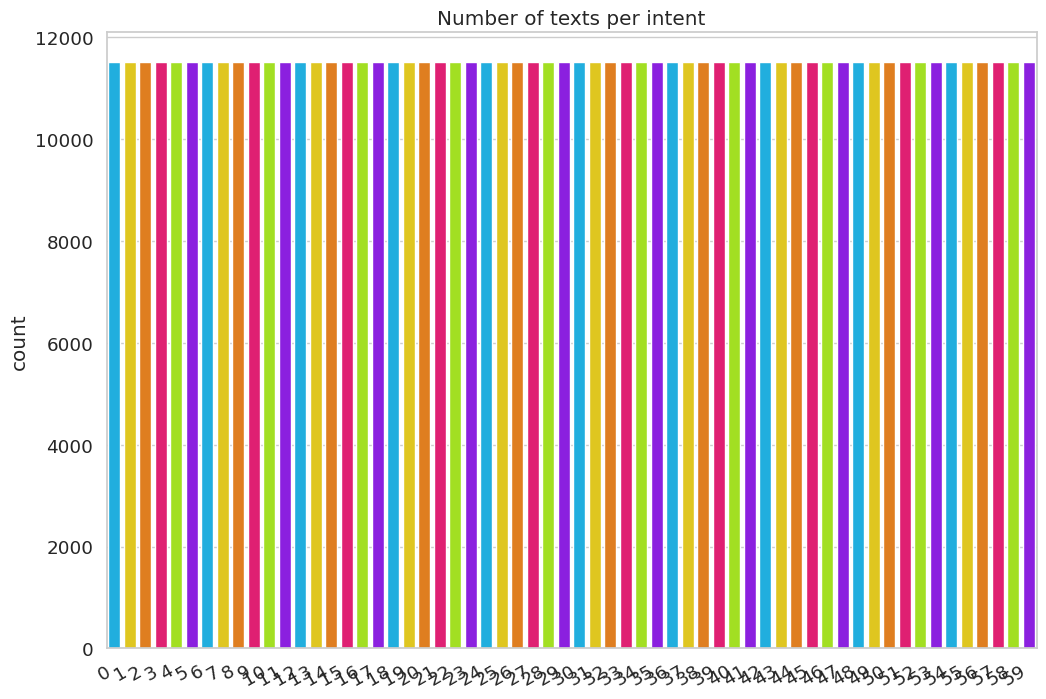

In [99]:
chart = sns.countplot(trainlabels, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');


In [100]:
testfeatures=test[['utt', 'intent']]
testlabels=testfeatures.pop("intent")
validfeatures=validation[['utt', 'intent']]
validlabels=validfeatures.pop("intent")

testfeatures=testfeatures.values
validfeatures=validfeatures.values

testlabels=binarizer.transform(testlabels.values)
validlabels=binarizer.transform(validlabels.values)

Preaparing the BERT model


In [138]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2"
encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1"

In [139]:
bert_preprocess_model = hub.KerasLayer(preprocess_url)

In [140]:
bert_model = hub.KerasLayer(encoder_url)

In [141]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(60, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [142]:
classifier_model = build_classifier_model()

In [143]:
classifier_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                              

Training the model

In [144]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [145]:
epochs=5
optimizer=tf.keras.optimizers.Adam(1e-5)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

history = classifier_model.fit(x=trainfeatures,
                               y=trainlabels,
                               validation_data=(validfeatures,validlabels),
                               batch_size=24,
                               epochs=epochs)

Epoch 1/5
480/480 [==============================] - 176s 303ms/step - loss: 2.6410 - categorical_accuracy: 0.4024 - val_loss: 1.3461 - val_categorical_accuracy: 0.6857
Epoch 2/5
480/480 [==============================] - 141s 293ms/step - loss: 1.1742 - categorical_accuracy: 0.7320 - val_loss: 0.7901 - val_categorical_accuracy: 0.8062
Epoch 3/5
480/480 [==============================] - 140s 292ms/step - loss: 0.7679 - categorical_accuracy: 0.8204 - val_loss: 0.6339 - val_categorical_accuracy: 0.8401
Epoch 4/5
480/480 [==============================] - 159s 331ms/step - loss: 0.5781 - categorical_accuracy: 0.8637 - val_loss: 0.5669 - val_categorical_accuracy: 0.8559
Epoch 5/5
480/480 [==============================] - 153s 319ms/step - loss: 0.4537 - categorical_accuracy: 0.8907 - val_loss: 0.5199 - val_categorical_accuracy: 0.8692


In [146]:
loss, accuracy = classifier_model.evaluate(testfeatures,testlabels)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

93/93 [==============================] - 18s 190ms/step - loss: 0.5463 - categorical_accuracy: 0.8611
Loss: 0.5463252067565918
Accuracy: 0.8611298203468323


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


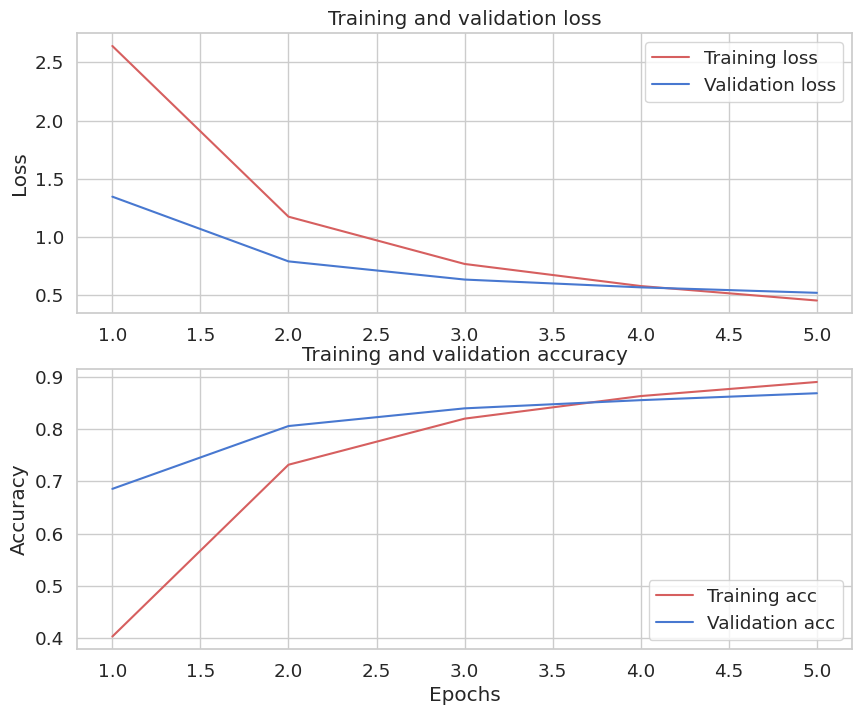

In [147]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

The model result 0.86 is satisfyingly enough to be presented. It is possible to change the BERT model to the largest one and get better results, but it will take several hours to be finished.

